#**Segmentación de imágenes con U-Net**
En este código, estamos importando las bibliotecas necesarias para implementar la arquitectura de red neuronal U-Net para la segmentación de imágenes. La U-Net es una red profunda utilizada para aplicaciones de segmentación y detección de objetos en imágenes.

Las bibliotecas que hemos importado incluyen TensorFlow para la implementación de la red neuronal, así como otras bibliotecas como NumPy y Matplotlib para el manejo de datos y la visualización de resultados. Además, también utilizamos la biblioteca tqdm para monitorear el progreso del bucle en tiempo real.

Además de la importación de bibliotecas, este código incluye la configuración de varias funciones y herramientas útiles para el procesamiento de imágenes, como la lectura y redimensionamiento de imágenes, la generación de datos de imagen, y el preprocesamiento necesario para la aplicación de la red U-Net en la segmentación de imágenes.

A medida que avanzamos en el código, estaremos aplicando la U-Net para realizar la segmentación de imágenes y mostraremos los resultados visuales para comprender mejor la eficacia de la red en esta tarea específica.

In [ ]:
#Importar librerias
import numpy as np
from numpy import max
import tensorflow as tf
import random
import cv2
import os
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from math import ceil
from skimage.transform import resize
from skimage.color import rgba2rgb
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import apply_affine_transform, apply_brightness_shift, apply_channel_shift


#Tener acceso a Drive
from google.colab import drive
drive.mount('/content/drive')
IMG_WIDTH = 1024 #inicial
IMG_HEIGHT = 1024  #inicial
# Rutas a los datos en Google Drive
TRAIN_PATH = '/content/drive/My Drive/MODULAR/training/roi/originales'
TEST_PATH = f'/content/drive/My Drive/MODULAR/testing/{IMG_WIDTH}x{IMG_HEIGHT}'  # Ajusta la ruta según el ancho y alto de la imagen

# Listar los archivos en las rutas
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)
# Listar los archivos en las rutas y ordenarlos
train_ids.sort()  # Ordena la lista alfabéticamente
test_ids.sort()

image_ids = [id_ for id_ in train_ids if "mask" not in id_]
mask_ids = [id_ for id_ in train_ids if "mask" in id_]
maskt_ids = [id_ for id_ in test_ids if "mask" in id_]
test_ids = [id_ for id_ in test_ids if "mask" not in id_]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tumor_131_roi.tif
tumor_131_mask_roi.tif


Primero, se define un conjunto de variables globales, como la carpeta de destino, el límite de tamaño, y las dimensiones iniciales de las imágenes. Luego, se implementan funciones para redimensionar las imágenes y procesar los datos. La función principal, process_data, utiliza una serie de condicionales para determinar cómo dividir y redimensionar las imágenes y máscaras según su tamaño inicial y la presencia de objetos en las máscaras.

El código itera a través de pares de imágenes y máscaras en un conjunto de datos de entrenamiento, aplicando la lógica de procesamiento definida en la función principal. Los parches resultantes se almacenan en las listas X e Y. Finalmente, los datos procesados se guardan en archivos .npy en un directorio específico.

In [ ]:
destination_folder = '/content/drive/My Drive/MODULAR/image_resize/rain'
limit = 2000
IMG_WIDTH = 1000 #inicial
IMG_HEIGHT = 1000  #inicial
IMG_CHANNELS = 3
X_train = []
Y_train = []
X = []
Y = []
nt = 0

def resize_images(img,mask):
    IMG_WIDTH = 1024 #inicial
    IMG_HEIGHT = 1024  #inicial
    IMG_CHANNELS = 3
    no_parche+=1
    resized_image = resize(img, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=False, mode='reflect')
    resized_mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=False, order=0, preserve_range=True)
    resized_image = (255 * resized_image).astype(np.uint8)
    resized_mask = resized_mask.astype(np.uint8)  # Asegurar que la máscara sea de tipo np.uint8
    return resized_image, resized_mask


def process_data(image, mask, img_id, mask_id):
        global IMG_WIDTH, IMG_HEIGHT
        height, width, *channels = image.shape
        print(height)
        if height > limit:
          if width > limit:
            horizontal=int(width/IMG_WIDTH)
            vertical=int(height/IMG_HEIGHT)
            print(f'Archivo {img_id} con medidas {height} es vertical {vertical} y {width} horizontal {horizontal}')
            print(f'Archivo {mask_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
            ancho= 0
            alto = 0
            final_a = 0
            final_h = 0
            parches = []
            parches_mask = []
            max_value = 0
            for i in range(1, horizontal+1):
              ancho = final_a +1
              final_h = 0
              if i == horizontal:
                final_a = width
              else:
                final_a = int((width/horizontal)*i)
              for j in range(1,vertical+1):
                alto = final_h+1
                if j == vertical:
                  final_h = height
                else:
                  final_h = int((height/vertical)*j)
                parche = image[alto:final_h,ancho:final_a,:]
                parche_mask = mask[alto:final_h,ancho:final_a]
                max_value = 0
                print(f'Archivo {img_id} con medidas {parche.shape} y {parche_mask.shape} con inicio en {ancho}, {final_a} y final en {alto},{final_h}')
                max_value = max(parche_mask)
                print(f'El valor máximo de la mascara en {img_id} es {max_value}')
                if max_value != 0:
                  resized_parche, resized_parche_mask = resize_images(parche,parche_mask)
                  if resized_parche is not None and resized_parche_mask is not None:
                    X.append(resized_parche)
                    Y.append(np.expand_dims(resized_parche_mask, axis=-1))
                else:
                  print(f'Ignorando parche en {img_id}')
          else:
            if width > 500:
              horizontal=int(width/IMG_WIDTH)
              vertical=int(height/IMG_HEIGHT)
              print(f'Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              print(f'Archivo {mask_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              ancho = 0
              final_a = width
              alto = 0
              final_h = 0
              parches = []
              parches_mask = []
              for i in range(1,vertical+1):
                alto = final_h + 1
                if i == vertical:
                  final_h = height
                else:
                  final_h=int((height/vertical)*i)
                parche = image[alto:final_h,ancho:final_a,:]
                parche_mask = mask[alto:final_h,ancho:final_a]
                print(f'Archivo {img_id} con medidas {parche.shape} y {parche_mask.shape} con inicio en {ancho}, {final_a} y final en {alto},{final_h}')
                max_value = 0
                max_value = max(parche_mask)
                print(f'El valor máximo de la mascara en {img_id} es {max_value}')
                if max_value != 0:
                  resized_parche, resized_parche_mask = resize_images(parche,parche_mask)
                  if resized_parche is not None and resized_parche_mask is not None:
                    X.append(resized_parche)
                    Y.append(np.expand_dims(resized_parche_mask, axis=-1))
                else:
                  print(f'Ignorando parche en {img_id}')
            else:
              print(f'Es necesario cortar de nuevo {img_id} porque {image.shape}')

        else:
          if width>limit:
            horizontal=int(width/IMG_WIDTH)
            vertical=int(height/IMG_HEIGHT)
            print(f'Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
            print(f'Archivo {mask_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
            ancho = 0
            alto = 0
            final_h = height
            final_a = 0
            parches=[]
            parches_mask=[]
            for i in range(1,horizontal+1):
              if i ==horizontal:
                final_a= width
              else:
                final_a=int((height/horizontal)*i)
              parche = image[alto:final_h,ancho:final_a,:]
              parche_mask = mask[alto:final_h,ancho:final_a]
              max_value = 0
              max_value = max(parche_mask)
              print(f'El valor máximo de la mascara en {img_id} es {max_value}')
              if max_value != 0:
                resized_parche, resized_parche_mask = resize_images(parche,parche_mask)
                if resized_parche is not None and resized_parche_mask is not None:
                   X.append(resized_parche)
                   Y.append(np.expand_dims(resized_parche_mask, axis=-1))
              else:
                print(f'Ignorando parche en {img_id}')
          else:
           if 700 <= height <= limit and 700 <= width <= limit:
              print(f'Todo nice aqui {img_id} con {image.shape}')
              max_value = 0
              max_value = max(mask)
              print(f'El valor máximo de la mascara en {img_id} es {max_value}')
              if max_value != 0:
                resized_parche, resized_parche_mask = resize_images(image,mask)
                if resized_parche is not None and resized_parche_mask is not None:
                   X.append(resized_parche)
                   Y.append(np.expand_dims(resized_parche_mask, axis=-1))
              else:
                print(f'Ignorando imagen {img_id}')
           else:
             if 400 < height < 1024 and 400 < width < 1024:
              horizontal=int(width/IMG_WIDTH)
              vertical=int(height/IMG_HEIGHT)
              IMG_HEIGHT = 1024
              IMG_WIDTH = 1024
              print(f'ENTRE 400 Y 1024: Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              padded_image = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
              padded_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=bool)
              padded_image[:height, :width, :] = image
              padded_mask[:height, :width] = mask
              max_value = 0
              max_value = max(padded_mask)
              print(f'El valor máximo de la mascara en {img_id} es {max_value}')
              if max_value != 0:
                resized_parche, resized_parche_mask = resize_images(padded_image,padded_mask)
                if resized_parche is not None and resized_parche_mask is not None:
                   X.append(resized_parche)
                   Y.append(np.expand_dims(resized_parche_mask, axis=-1))
              else:
                print(f'Ignorando parche en {img_id}')
             else:
              if height > 1024:
                IMG_HEIGHT = 1024
                IMG_WIDTH = 1024
                horizontal=int(width/IMG_WIDTH)
                vertical=int(height/IMG_HEIGHT)
                padded_image = np.zeros((height, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
                padded_mask = np.zeros((height, IMG_WIDTH), dtype=bool)
                padded_image[:height, :width, :] = image
                padded_mask[:height, :width] = mask
                max_value = 0
                max_value = max(padded_mask)
                print(f'El valor máximo de la mascara en {img_id} es {max_value}')
                if max_value != 0:
                  resized_parche, resized_parche_mask = resize_images(padded_image,padded_mask)
                  if resized_parche is not None and resized_parche_mask is not None:
                    X.append(resized_parche)
                    Y.append(np.expand_dims(resized_parche_mask, axis=-1))
                else:
                  print(f'Ignorando parche en {img_id}')
                print(f'HEIGHT >1024: Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              elif width >1024:
                IMG_HEIGHT = 1024
                IMG_WIDTH = 1024
                horizontal=int(width/IMG_WIDTH)
                vertical=int(height/IMG_HEIGHT)
                padded_image = np.zeros((IMG_HEIGHT, width, IMG_CHANNELS), dtype=np.uint8)
                padded_mask = np.zeros((IMG_HEIGHT, width), dtype=bool)
                padded_image[:height, :width, :] = image
                padded_mask[:height, :width] = mask
                max_value = max(padded_mask)
                print(f'El valor máximo de la mascara en {img_id} es {max_value}')
                if max_value != 0:
                  resized_parche, resized_parche_mask = resize_images(padded_image,padded_mask)
                  if resized_parche is not None and resized_parche_mask is not None:
                    X.append(resized_parche)
                    Y.append(np.expand_dims(resized_parche_mask, axis=-1))
                else:
                  print(f'Ignorando parche en {img_id}')
                print(f'WIDTH > 1024: Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              else:
                print(f'Es necesario cortar de nuevo {img_id} porque {image.shape}')



        return X,Y


# Logic for processing training data
print('Resizing training images and masks')
for img_id, mask_id in zip(image_ids, mask_ids):
    IMG_WIDTH = 1000
    IMG_HEIGHT = 1000
    IMG_CHANNELS = 3
    image = imread(os.path.join(TRAIN_PATH, img_id))[:,:,:IMG_CHANNELS]
    mask = imread(os.path.join(TRAIN_PATH, mask_id))
    X_train, Y_train = process_data(image, mask, img_id, mask_id)


directory = f'/content/drive/My Drive/MODULAR/training/roi/variables/{IMG_WIDTH}x{IMG_HEIGHT}/'

# Comprobar si el directorio ya existe
if not os.path.exists(directory):
    # Crear el directorio si no existe
    os.makedirs(directory)

# Guardar los archivos en el directorio
np.save(f'{directory}X_train_{IMG_WIDTH}_roi_test_3.npy', X_train)
np.save(f'{directory}Y_train_{IMG_WIDTH}_roi_test_3.npy', Y_train)

Resizing training images and masks
3284
Archivo tumor_001_roi.tif con medidas (3284, 1060, 3) es vertical 3 y horizontal 1
Archivo tumor_001_mask_roi.tif con medidas (3284, 1060, 3) es vertical 3 y horizontal 1
Archivo tumor_001_roi.tif con medidas (1093, 1060, 3) y (1093, 1060) con inicio en 0, 1060 y final en 1,1094
El valor máximo de la mascara en tumor_001_roi.tif es 1
Archivo tumor_001_roi.tif con medidas (1094, 1060, 3) y (1094, 1060) con inicio en 0, 1060 y final en 1095,2189
El valor máximo de la mascara en tumor_001_roi.tif es 1
Archivo tumor_001_roi.tif con medidas (1094, 1060, 3) y (1094, 1060) con inicio en 0, 1060 y final en 2190,3284
El valor máximo de la mascara en tumor_001_roi.tif es 1
1314
Todo nice aqui tumor_002_roi.tif con (1314, 1310, 3)
El valor máximo de la mascara en tumor_002_roi.tif es 1
2025
Archivo tumor_003_roi.tif con medidas 2025 es vertical 2 y 2025 horizontal 2
Archivo tumor_003_mask_roi.tif con medidas (2025, 2025, 3) es vertical 2 y horizontal 2
Arch

# **Características Específicas de la U-Net**
### **Convoluciones**
Las capas de convolución en la red U-Net utilizan filtros de convolución para extraer características de las imágenes de entrada. En el código, las capas de convolución se definen con el método Conv2D de TensorFlow, donde se especifica el número de filtros, el tamaño del kernel y la función de activación ReLU para introducir la no linealidad en la red.

### **MaxPooling**
Las capas de MaxPooling se utilizan para reducir la resolución espacial de la representación de la imagen, lo que ayuda a reducir el costo computacional y a extraer características importantes a diferentes escalas. En el código, se emplea el método MaxPooling2D para reducir la resolución espacial en un factor de 2 en cada dimensión.

### **Funciones de Activación**
La función de activación ReLU (Rectified Linear Unit) se utiliza después de cada capa convolucional para introducir la no linealidad en la red y permitir la representación de características complejas en los datos de entrada.

### **Capas de Dropout**
Las capas de Dropout se utilizan para reducir el sobreajuste en el modelo al desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento. En el código, se utiliza la función Dropout de TensorFlow para regularizar el modelo y evitar el sobreajuste.

### **Capas de Concatenación**
Las capas de concatenación se utilizan para fusionar características de diferentes capas en la red. En el código, se emplea el método concatenate para fusionar las características de las capas de contracción con las de expansión.

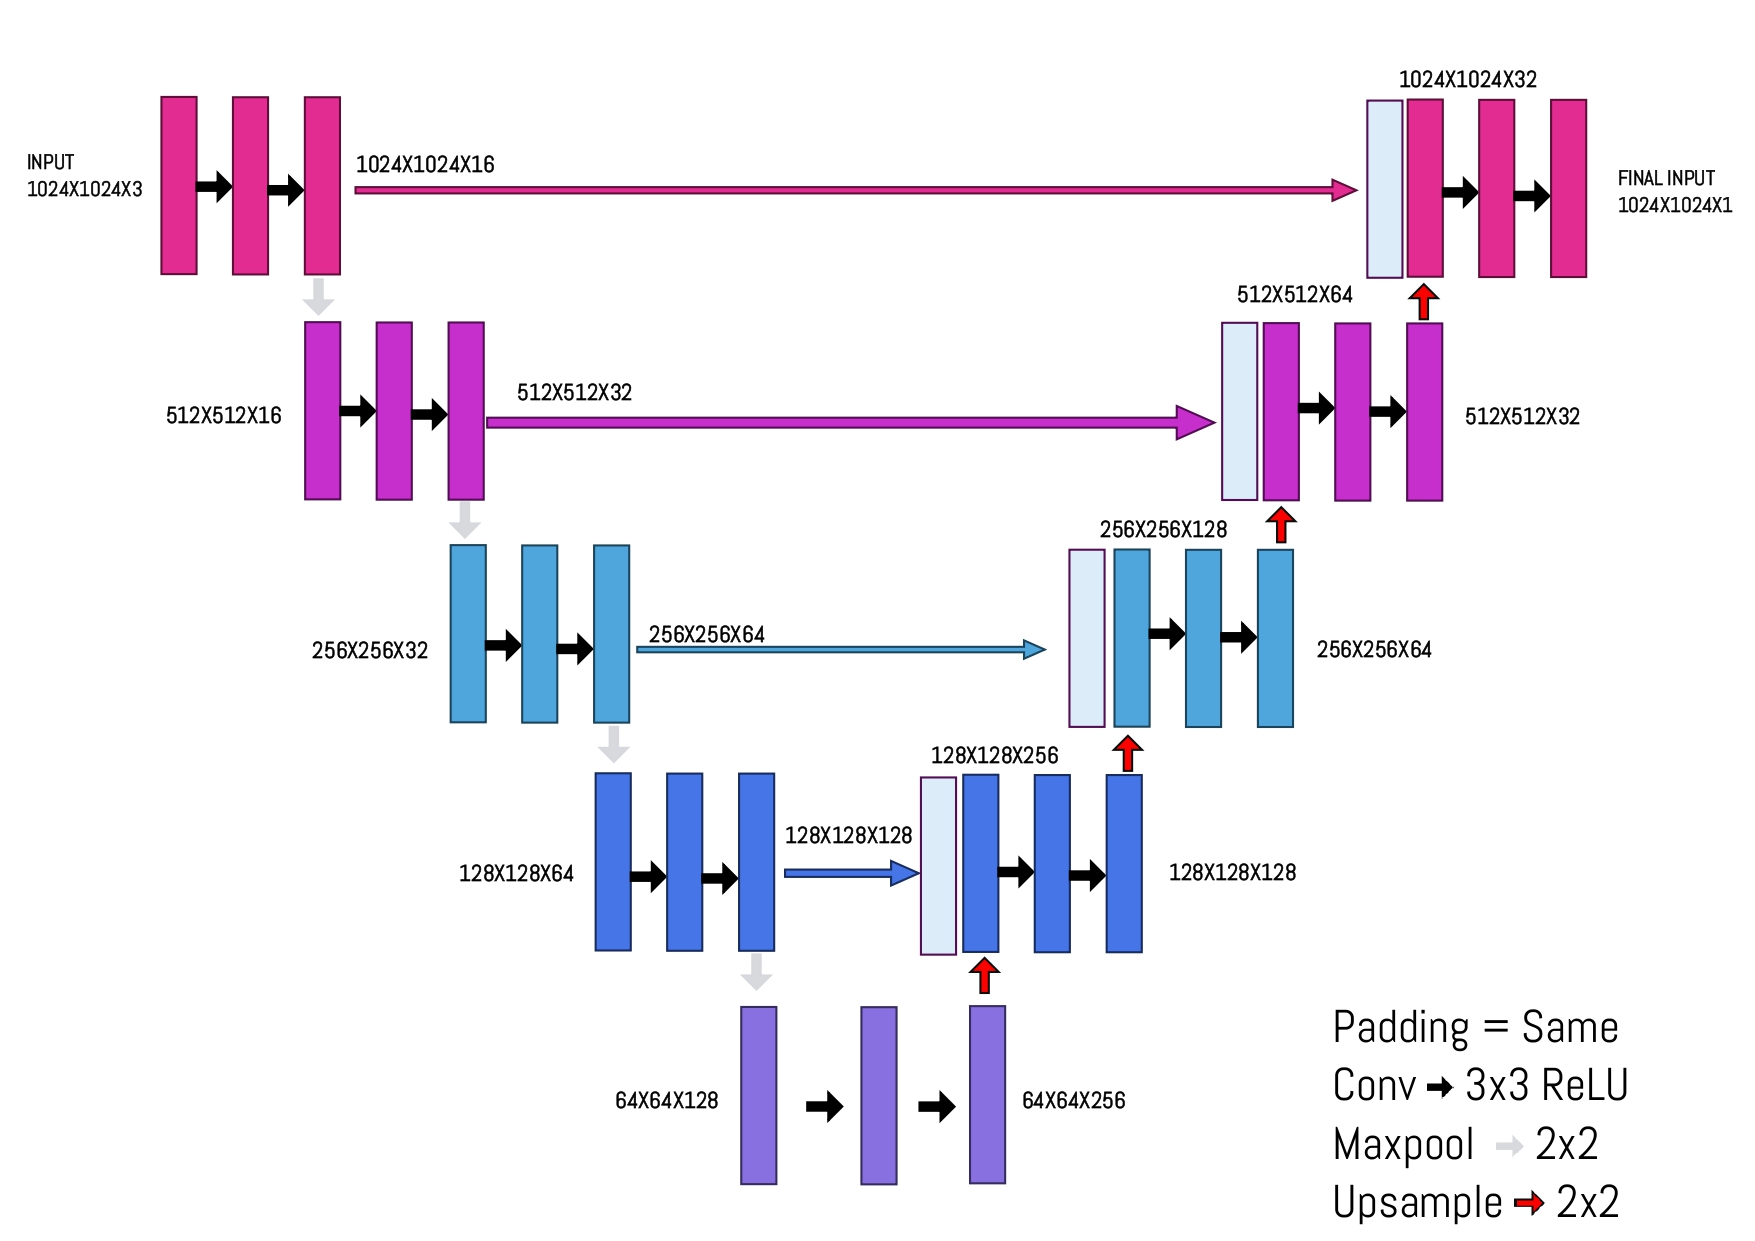

In [ ]:
#Construccion de U-NET
#MODELO ORIGINAL
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1024, 1024, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 16)       448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 1024, 1024, 16)       0         ['conv2d[0][0]']              
                                                                                              

El fragmento de código presentado configura y aplica varios objetos de devolución de llamada (*callback*) durante el proceso de entrenamiento de la red neuronal convolucional *U-Net*. El propósito de estas devoluciones de llamada es monitorear y realizar ciertas acciones durante el entrenamiento del modelo para mejorar su rendimiento y evitar problemas como el sobreajuste.

La devolución de llamada *ModelCheckpoint* se utiliza para guardar el modelo en un archivo '.h5' después de cada época si se ha obtenido una mejora en el rendimiento. Esto se realiza para almacenar el mejor modelo obtenido durante el entrenamiento.

Las devoluciones de llamada también incluyen *EarlyStopping*, que se activa cuando la pérdida de validación no mejora durante un número específico de épocas, en este caso, *dos épocas*. Esto ayuda a detener el entrenamiento prematuramente si no se observa una mejora en la pérdida de validación.

Otra devolución de llamada es *TensorBoard*, que registra métricas y la pérdida durante el entrenamiento para su visualización posterior.

El modelo se entrena con los datos de entrenamiento y con un 10% de los datos utilizados para validación. El tamaño del lote se establece en **2**, y el número de épocas para el entrenamiento es **25**.

***Modificable**

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/MODULAR/modelos/{IMG_WIDTH}x{IMG_HEIGHT}/checkpoints/modular.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs')]

batch_size=1
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=25, callbacks=callbacks)

# Guardar el modelo
model.save(f'/content/drive/My Drive/MODULAR/modelos/{IMG_WIDTH}x{IMG_HEIGHT}/trained_model_{IMG_WIDTH}_{batch_size}_roi_test_3(2).hdf5')
model.save(f'/content/drive/My Drive/MODULAR/modelos/{IMG_WIDTH}x{IMG_HEIGHT}/trained_model_{IMG_WIDTH}_{batch_size}_roi_test_3(2).h5')
model.save(f'/content/drive/My Drive/MODULAR/modelos/{IMG_WIDTH}x{IMG_HEIGHT}/trained_model_{IMG_WIDTH}_{batch_size}_roi_test_3(2).keras')

Epoch 1/25
812/812 [==============================] - 155s 191ms/step - loss: 0.3912 - accuracy: 0.8278 - val_loss: 0.5317 - val_accuracy: 0.7329
Epoch 2/25
812/812 [==============================] - 155s 191ms/step - loss: 0.3703 - accuracy: 0.8427 - val_loss: 0.3885 - val_accuracy: 0.8323
Epoch 3/25
812/812 [==============================] - 155s 191ms/step - loss: 0.3586 - accuracy: 0.8478 - val_loss: 0.4517 - val_accuracy: 0.8144
Epoch 4/25
812/812 [==============================] - 155s 191ms/step - loss: 0.3550 - accuracy: 0.8498 - val_loss: 0.4711 - val_accuracy: 0.7853
Epoch 5/25
812/812 [==============================] - 155s 191ms/step - loss: 0.3414 - accuracy: 0.8583 - val_loss: 0.3981 - val_accuracy: 0.8259
Epoch 6/25
812/812 [==============================] - 155s 191ms/step - loss: 0.3389 - accuracy: 0.8552 - val_loss: 0.3190 - val_accuracy: 0.8767
Epoch 7/25
812/812 [==============================] - 155s 190ms/step - loss: 0.3286 - accuracy: 0.8636 - val_loss: 0.5609 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#**Evaluación de Modelos de Segmentación de Imágenes U-Net en Google Colab: Un Enfoque Integral**

En este trabajo, se presenta un código en Python desarrollado en el entorno de Google Colab para la evaluación de modelos de segmentación de imágenes basados en la arquitectura U-Net. El código comienza montando Google Drive para acceder a los datos necesarios y define una función para calcular el Índice de Jaccard (IoU), una métrica crucial para medir la similitud entre conjuntos, en este caso, entre las máscaras reales y las predicciones del modelo.

El núcleo del script carga un modelo U-Net preentrenado desde una ubicación específica y establece las rutas para la carpeta de pruebas y la carpeta de salida, donde se almacenarán las predicciones generadas. A continuación, el código itera sobre los archivos de la carpeta de pruebas, cargando las imágenes y máscaras correspondientes. Realiza predicciones de segmentación utilizando el modelo cargado y calcula el IoU para evaluar la precisión del modelo en cada imagen procesada.

Además de la evaluación cuantitativa, el código incluye una visualización detallada de los resultados. Detecta los contornos en las máscaras binarizadas y superpone estos contornos tanto en las imágenes originales como en las máscaras predichas. Aunque se han incluido secciones comentadas para visualizar estas imágenes resultantes, actualmente están deshabilitadas en la ejecución del código.

Este enfoque integral proporciona una herramienta efectiva para la evaluación del rendimiento de modelos de segmentación de imágenes basados en U-Net. Las visualizaciones resultantes, almacenadas en una carpeta de salida designada, permiten un análisis detallado de las áreas de interés identificadas. Este trabajo facilita la comprensión y visualización de la efectividad del modelo en la tarea crítica de segmentación de imágenes en el contexto de aprendizaje profundo.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ENTRE 400 Y 1024: Archivo test_010_roi.tif con medidas (685, 652, 3) es vertical 0 y horizontal 0
1/1 [==============================] - 1s 1s/step


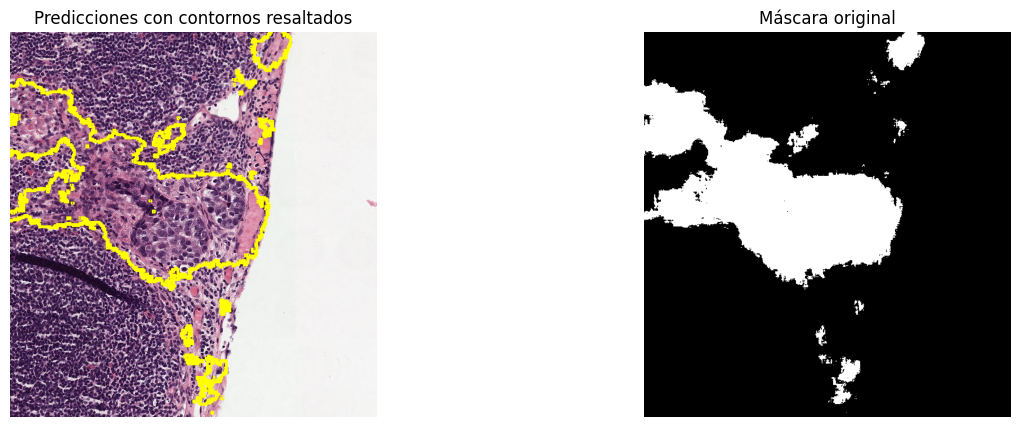

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage import feature
from skimage.measure import find_contours
from sklearn.metrics import roc_auc_score
from skimage.segmentation import find_boundaries
from skimage.draw import set_color
from skimage.draw import rectangle_perimeter
import torch
import sys
import cv2


# Tener acceso a Drive
from google.colab import drive
drive.mount('/content/drive')


def resize_images(img):
    IMG_WIDTH = 1024 #inicial
    IMG_HEIGHT = 1024  #inicial
    IMG_CHANNELS = 3
    resized_image = resize(img, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=False, mode='reflect')
    resized_image = (255 * resized_image).astype(np.uint8)
    return resized_image

def prediction(test_img):
    # Realizar la predicción
    global loaded_model
    resized_img = resize_images(test_img)
    resized_img = resized_img[np.newaxis, ...]
    prediction = loaded_model.predict(resized_img)
    # Binarizar la máscara de predicción y redimensionarla a la forma de la imagen original
    binary_prediction =  resize(prediction[0, ..., 0], (test_img.shape[0], test_img.shape[1]), mode='constant', preserve_range=True)
    # Asegurarse de que los valores estén en el rango adecuado
    binary_prediction = (binary_prediction - binary_prediction.min()) / (binary_prediction.max() - binary_prediction.min())
    binary_prediction = (binary_prediction > 0.5).astype(np.uint8)
    # Detectar contornos en la máscara binarizada
    contours = find_contours(binary_prediction, 0.5)
    # Crear una imagen en blanco para superponer las máscaras
    green_color = [0, 255, 0]
    yellow_color = [255, 255, 0]
    # Superponer la máscara en la imagen original
    pred = np.copy(test_img)
    pred[binary_prediction == 1] = [0, 255, 0]  # Resaltar en verde las áreas predichas como tumor en la imagen original

    overlay_pred = np.copy(test_img)
    for contour in contours:
        for point in contour:
            y, x = point
            rr, cc = rectangle_perimeter((y-1, x-1), extent=(3, 3), shape=overlay_pred.shape)  # Definir un rectángulo alrededor del punto para aumentar el grosor
            overlay_pred[rr, cc] = yellow_color  # Resaltar en amarillo los píxeles adyacentes para hacer los contornos más gruesos



    return overlay_pred, pred, binary_prediction

def process_data(image, img_id):
        IMG_WIDTH = 1000
        IMG_HEIGHT = 1000
        limit = 2000
        height, width, *channels = image.shape
        pred = np.zeros((height, width, 3), dtype=np.uint8)
        binary = np.zeros((height, width), dtype=np.uint8)
        contornos = np.zeros((height, width, 3), dtype=np.uint8)
        if height > limit:
          if width > limit:
            horizontal=int(width/IMG_WIDTH)
            vertical=int(height/IMG_HEIGHT)
            ancho= 0
            alto = 0
            final_a = 0
            final_h = 0
            parches = []
            max_value = 0
            print(f'Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
            for i in range(1, horizontal+1):
              ancho = final_a
              final_h = 0
              if i == horizontal:
                final_a = width
              else:
                final_a = int((width/horizontal)*i)
              for j in range(1,vertical+1):
                alto = final_h
                if j == vertical:
                  final_h = height
                else:
                  final_h = int((height/vertical)*j)
                parche = image[alto:final_h,ancho:final_a,:]
                overlay_pred, predic, binary_prediction = prediction(parche)
                binary[alto:final_h,ancho:final_a] = binary_prediction
                pred[alto:final_h,ancho:final_a,:] = predic
                contornos[alto:final_h,ancho:final_a,:] = overlay_pred
          else:
            if width > 500:
              horizontal=int(width/IMG_WIDTH)
              vertical=int(height/IMG_HEIGHT)
              print(f'Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              ancho = 0
              final_a = width
              alto = 0
              final_h = 0
              parches = []
              for i in range(1,vertical+1):
                alto = final_h
                if i == vertical:
                  final_h = height
                else:
                  final_h=int((height/vertical)*i)
                parche = image[alto:final_h,ancho:final_a,:]
                overlay_pred, predic, binary_prediction = prediction(parche)
                binary[alto:final_h,ancho:final_a] = binary_prediction
                pred[alto:final_h,ancho:final_a,:] = predic
                contornos[alto:final_h,ancho:final_a,:] = overlay_pred
        else:
          if width>limit:
            horizontal=int(width/IMG_WIDTH)
            vertical=int(height/IMG_HEIGHT)
            print(f'Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
            ancho = 0
            alto = 0
            final_h = height
            final_a = 0
            parches=[]
            for i in range(1,horizontal+1):
              if i ==horizontal:
                final_a= width
              else:
                final_a=int((height/horizontal)*i)
              parche = image[alto:final_h,ancho:final_a,:]
              overlay_pred, predic, binary_prediction = prediction(parche)
              binary[alto:final_h,ancho:final_a] = binary_prediction
              pred[alto:final_h,ancho:final_a,:] = predic
              contornos[alto:final_h,ancho:final_a,:] = overlay_pred
          else:
           if 700 <= height <= limit and 700 <= width <= limit:
              print(f'Todo nice aqui {img_id} con {image.shape}')
              overlay_pred, predic, binary_prediction = prediction(image)
              binary = binary_prediction
              pred = predic
              contornos = overlay_pred
           else:
             if 400 < height < 1024 and 400 < width < 1024:
              horizontal=int(width/IMG_WIDTH)
              vertical=int(height/IMG_HEIGHT)
              IMG_HEIGHT = 1024
              IMG_WIDTH = 1024
              print(f'ENTRE 400 Y 1024: Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              padded_image = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
              padded_image[:height, :width, :] = image
              overlay_pred, predic, binary_prediction = prediction(padded_image)
              binary = binary_prediction[:height,:width]
              pred = predic[:height,:width,:]
              contornos = overlay_pred[:height,:width,:]
             else:
              if height > 1024:
                IMG_HEIGHT = 1024
                IMG_WIDTH = 1024
                horizontal=int(width/IMG_WIDTH)
                vertical=int(height/IMG_HEIGHT)
                padded_image = np.zeros((height, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
                padded_image[:height, :width, :] = image
                overlay_pred, predic, binary_prediction = prediction(padded_image)
                binary = binary_prediction[:height,:width]
                pred = predic[:height,:width,:]
                contornos = overlay_pred[:height,:width,:]
                print(f'HEIGHT >1024: Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              elif width >1024:
                IMG_HEIGHT = 1024
                IMG_WIDTH = 1024
                horizontal=int(width/IMG_WIDTH)
                vertical=int(height/IMG_HEIGHT)
                padded_image = np.zeros((IMG_HEIGHT, width, IMG_CHANNELS), dtype=np.uint8)
                padded_image[:height, :width, :] = image
                overlay_pred, predic, binary_prediction = prediction(padded_image)
                binary = binary_prediction[:height,:width]
                pred = predic[:height,:width,:]
                contornos = overlay_pred[:height,:width,:]
                print(f'WIDTH > 1024: Archivo {img_id} con medidas {image.shape} es vertical {vertical} y horizontal {horizontal}')
              else:
                print(f'No es posible utilizar {img_id} debido a sus dimensiones {image.shape}')

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(contornos)
        axes[0].set_title('Predicciones con contornos resaltados')
        axes[0].axis('off')

        axes[1].imshow(binary, cmap='gray')
        axes[1].set_title('Máscara predicha')
        axes[1].axis('off')



IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 3
batch_size = 1

loaded_model = tf.keras.models.load_model(f'/content/drive/My Drive/MODULAR/modelos/{IMG_WIDTH}x{IMG_HEIGHT}/trained_model_{IMG_WIDTH}_{batch_size}_roi_test_3.hdf5', custom_objects={'<lambda>': lambda x: x}, compile=False, safe_mode=False)

testing_folder_path = f'/content/drive/My Drive/MODULAR/testing/roi/originales/'
output_folder = f'/content/drive/My Drive/MODULAR/predicciones/{IMG_WIDTH}x{IMG_HEIGHT}/'
test_image_name = 'test_010_roi.tif'
test_image_path = os.path.join(testing_folder_path, test_image_name)  # Ruta de la imagen de prueba

# Cargar la imagen de prueba y la máscara
test_img = imread(test_image_path)[:,:,:3]
process_data(test_img, test_image_name)
